In [35]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf



In [36]:
# 7 Assests (NVIDIA, Advanced Micro Devices, Gamestop, Walt Disney Co, Pfizer inc, Costco, Target Corp)
tickers =['NVDA','AMD','GME','DIS','PFE','COST','TGT']
etfs=['spy','iwm','dia']

tickers, etfs = [ticker.upper() for ticker in tickers], [
    etf.upper() for etf in etfs
]
# Gathers asset's data from past 10 years (3650 days) to today 
start_date = dt.datetime.today() - pd.Timedelta(3650, "d")
end_date = dt.datetime.today()

#Downloads stock data
tickers_data =yf.download (start=start_date,end=end_date, tickers= tickers + etfs, auto_adjust=False)['Adj Close']
tickers_data.head()

analysis = pd.DataFrame(index=tickers)

#Portfolio Wieght (must be equally weighted!) = 1/7 (since there are seven assests)
analysis['Portfolio Weight']= 100/len(tickers)

[*********************100%***********************]  10 of 10 completed


In [37]:
daily_returns = tickers_data.pct_change()

# drops row with NaN values: the value of the first row because the numerator = 0 
# when calculating daily returns since there is no data from previous day to calculate for the next day.
daily_returns = daily_returns.drop(index = daily_returns.index[0], axis=0, inplace=False) 
daily_returns

Ticker,AMD,COST,DIA,DIS,GME,IWM,NVDA,PFE,SPY,TGT
Date,,,,,,,,,,
2015-04-22,-0.029787,-0.002443,0.004463,0.002414,0.003992,0.001514,0.011333,0.001146,0.004914,0.001107
2015-04-23,0.021930,0.002177,0.001721,0.009820,0.001988,0.004534,-0.004034,0.012310,0.002516,0.007254
2015-04-24,-0.012876,0.005567,0.000942,0.004862,0.009672,-0.003326,-0.008550,-0.002545,0.002321,0.009398
2015-04-27,0.017391,-0.007831,-0.002049,0.005752,-0.010563,-0.011044,0.007716,-0.019280,-0.004158,-0.015961
2015-04-28,-0.012821,-0.002382,0.003718,-0.002179,0.002731,0.005543,0.004955,-0.003180,0.003178,0.001597
...,...,...,...,...,...,...,...,...,...,...
2025-04-11,0.052988,-0.000933,0.015745,-0.003989,0.055156,0.014584,0.031235,0.014822,0.017843,0.000755
2025-04-14,0.011777,0.016514,0.008733,-0.002709,0.021970,0.011770,-0.001983,0.009585,0.009701,0.020155
2025-04-15,0.008360,-0.002451,-0.004218,0.004134,-0.010378,0.001233,0.013459,0.014467,-0.002801,-0.027153


In [38]:
# Column 3: Calculates annualized volatility trailing over 3-months 
volatility_three = daily_returns[tickers][-63:].std() * (252 ** (1/2)) * 100

# Drop NaN values from the trailing window
volatility_three[tickers]
print(volatility_three)
analysis['Annualized Volatility'] = volatility_three

Ticker
NVDA    78.516160
AMD     72.436674
GME     74.557206
DIS     42.270957
PFE     25.887852
COST    30.651288
TGT     43.465336
dtype: float64


source for Columns 4-6: https://www.youtube.com/watch?v=_8DZxoEwpwE

In [39]:
# Slices daily returns to gather data trailing 12 months
daily_returns= daily_returns[-252:] #252 days to 1 year's worth of trading days
daily_returns

#--------------------------------Beta against SPY
covariance = daily_returns.cov()
variance = np.var(daily_returns['SPY'])
beta =[] 

for i in tickers:
    asset_beta = covariance.loc[i,'SPY']/variance
    beta.append(asset_beta)

print('beta vs spy:',beta)
analysis['Beta vs SPY']=beta

#----------------------------------Beta against IWM 
covariance2= daily_returns.cov()
variance2= np.var(daily_returns['IWM'])
beta2 =[] 

for i in tickers:
    asset_beta2 = covariance2.loc[i,'IWM']/variance2
    beta2.append(asset_beta2)
print('beta vs iwm:', beta2)
analysis['Beta vs IWM']=beta2

#----------------------------------Beta against DIA
covariance3= daily_returns.cov()
variance3= np.var(daily_returns['DIA'])
beta3 =[] 

for i in tickers:
    asset_beta3 = covariance3.loc[i,'DIA']/variance3
    beta3.append(asset_beta3)
print('beta vs dia',beta3)
analysis['Beta vs DIA']=beta3

beta vs spy: [2.1602920284146663, 2.037688030880747, 1.074248728705851, 0.9246767571690957, 0.35098584145128603, 0.6218904804419613, 0.7949212894538025]
beta vs iwm: [1.2306016161719955, 1.3697282283673482, 1.116704931797524, 0.6717161968414909, 0.3178988607385985, 0.3535388765495829, 0.7690735849636555]
beta vs dia [1.6249699158564455, 1.916368708822658, 1.0404128160402015, 1.120525765288182, 0.5712260495995897, 0.6655120996715349, 0.9552303501822579]


In [40]:
#Columns 7+8: Average and max weekly drawdowns
def drawdowns(values):
        
    # Weekly min and max calculations
    weekly_min = values.rolling(5).min()
    weekly_max = values.rolling(5).max()

    # Weekly drawdown calculations for the latest year
    weekly_dd = ((weekly_min - weekly_max) / weekly_max)[-252:] * 100

    # Calculate mean and max for the latest year
    return weekly_dd.mean(), weekly_dd.min()

analysis['Avg weekly Drawdown'], analysis['Max weekly Drawdown'] = drawdowns(tickers_data)

print(analysis)

      Portfolio Weight  Annualized Volatility  Beta vs SPY  Beta vs IWM  \
NVDA         14.285714              78.516160     2.160292     1.230602   
AMD          14.285714              72.436674     2.037688     1.369728   
GME          14.285714              74.557206     1.074249     1.116705   
DIS          14.285714              42.270957     0.924677     0.671716   
PFE          14.285714              25.887852     0.350986     0.317899   
COST         14.285714              30.651288     0.621890     0.353539   
TGT          14.285714              43.465336     0.794921     0.769074   

      Beta vs DIA  Avg weekly Drawdown  Max weekly Drawdown  
NVDA     1.624970            -7.479925           -19.562567  
AMD      1.916369            -6.441486           -24.038462  
GME      1.040413           -11.146903           -67.343590  
DIS      1.120526            -3.150345           -16.510009  
PFE      0.571226            -3.187292           -11.578949  
COST     0.665512          

In [41]:
#Column9: total returns trailing 10 years
current_price= (tickers_data[tickers].iloc[-1]) # Returns the latest price for each asset 

starting_price= tickers_data[tickers].iloc[0] #returns the starting price for each asset


for i in tickers:
    total_return=(((current_price-starting_price)/starting_price)*100).round(2)
total_return=total_return.dropna() 
   
print(total_return)

#Total Returns
analysis['Total Returns']= total_return

Ticker
NVDA    18996.61
AMD      3623.40
GME       255.85
DIS       -14.45
PFE        -0.04
COST      705.34
TGT        52.19
dtype: float64


In [42]:
starting_price= tickers_data[tickers].iloc[0] #returns the starting price for each asset
starting_price

for i in tickers:
    total_return=(((current_price-starting_price)/starting_price)*100).round(2)
total_return=total_return.dropna() 
   
print(total_return)

#Total Returns
analysis['Total Returns']= total_return

Ticker
NVDA    18996.61
AMD      3623.40
GME       255.85
DIS       -14.45
PFE        -0.04
COST      705.34
TGT        52.19
dtype: float64


In [43]:
#Column 10: Annualized Total returns
annual_return = (((1+total_return)**(252/2520)-1)*100).round(2)
print(annual_return)

#Annualized Total Return
analysis['Annualized Total Return']= annual_return

Ticker
NVDA    167.84
AMD     126.95
GME      74.17
DIS        NaN
PFE      -0.41
COST     92.71
TGT      48.79
dtype: float64


In [44]:
analysis

,Portfolio Weight,Annualized Volatility,Beta vs SPY,Beta vs IWM,Beta vs DIA,Avg weekly Drawdown,Max weekly Drawdown,Total Returns,Annualized Total Return
NVDA,14.285714,78.516160,2.160292,1.230602,1.624970,-7.479925,-19.562567,18996.61,167.84
AMD,14.285714,72.436674,2.037688,1.369728,1.916369,-6.441486,-24.038462,3623.40,126.95
GME,14.285714,74.557206,1.074249,1.116705,1.040413,-11.146903,-67.343590,255.85,74.17
DIS,14.285714,42.270957,0.924677,0.671716,1.120526,-3.150345,-16.510009,-14.45,NaN
PFE,14.285714,25.887852,0.350986,0.317899,0.571226,-3.187292,-11.578949,-0.04,-0.41
COST,14.285714,30.651288,0.621890,0.353539,0.665512,-2.819960,-11.191602,705.34,92.71
TGT,14.285714,43.465336,0.794921,0.769074,0.955230,-4.277259,-21.774872,52.19,48.79


Table #2

In [45]:
#Column 1: 
tickers_data[etfs]
portfolio_risk=pd.DataFrame(index=etfs)


In [46]:
#Calculates equally weighted portfolio returns 

daily_returns["equal_weight"]= daily_returns[tickers].mean(axis=1) # using axis=1, calculates the mean going across each row
tickers_data["equal_weight"]= tickers_data[tickers].mean(axis=1) 

#Column 2: 1 yr Correlation between ETFs and equally weighted portfolio
portfolio_risk['Correlation']=daily_returns[-252:].corr().equal_weight

#column 3: 1 yr Covarriance between ETFs and equally weighted portfolio
portfolio_risk['Covarriance']= daily_returns[-252:].cov().equal_weight*10000


/var/folders/q9/1h42_3tn705_j_750qfm6dz00000gn/T/ipykernel_6324/850825956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_returns["equal_weight"]= daily_returns[tickers].mean(axis=1) # using axis=1, calculates the mean going across each row


In [47]:
# Gather returns data 10 years
trailing_returns = tickers_data.pct_change()

# Calculate trailing portfolio returns
trailing_portfolio_return = trailing_returns[tickers].mean(axis=1) #axis=1 computes along row-wise

# Gathers trailing returns into ETF 
trailing_etf_returns = trailing_returns[etfs]

# Formula: Tracking error = stan.dev(portfolio returns - benchmark returns)

    #Difference between tickers returns and etf returns
tracking_errors = trailing_etf_returns.sub(trailing_portfolio_return, axis=0)# axis=0 computes alongcolumn-wise

    #Standard deviation of tracking errors 
tracking_errors_std = tracking_errors.std()

# Adds tracking error column to the portfolio_risk dataframe as a percentage
portfolio_risk['Tracking Error'] = tracking_errors_std

In [48]:
#Sharpe ratio
#Riskfree rate: 5.17% over 1 yr
RF=0.0513/252

#Gather 1yr of returns data
trailing_etf_returns= trailing_etf_returns[-252:]

#Volatility
volatility = trailing_etf_returns.std() * (252 ** (1/2))

sharpe_ratio=(trailing_etf_returns.rolling(5).mean()- RF)*5/volatility
sharpe_ratio=sharpe_ratio.mean(axis=0)
portfolio_risk['Sharpe Ratio'] = sharpe_ratio

In [49]:
#Annualized Volatility Spread
etf_volatility = daily_returns[etfs].std() * (252 ** (1/2))
port_volatility = daily_returns['equal_weight'].std() * (252 ** (1/2))
av_spread= port_volatility-etf_volatility
portfolio_risk['Volatility Spread']= av_spread

In [50]:
portfolio_risk

,Correlation,Covarriance,Tracking Error,Sharpe Ratio,Volatility Spread
SPY,0.691591,1.734133,0.013022,0.004581,0.125417
IWM,0.612752,1.859982,0.013862,-0.004541,0.084067
DIA,0.578028,1.222194,0.014078,0.003912,0.156197


<Axes: xlabel='Ticker', ylabel='Ticker'>

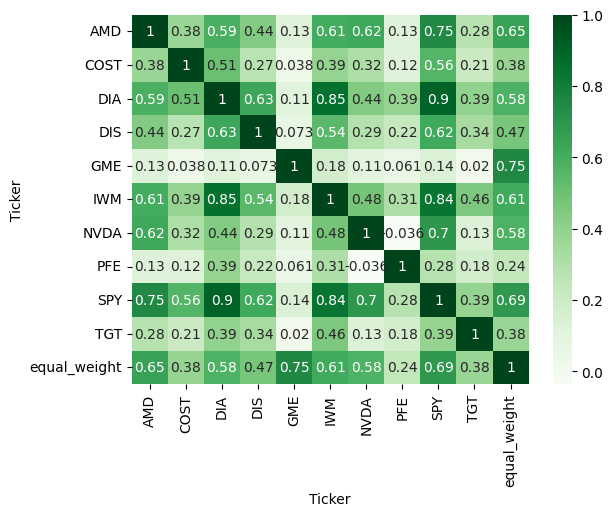

In [51]:
#Correlation Matrix
sns.heatmap(daily_returns[-252:].corr(), cmap= 'Greens',annot=True)

# Exporting dataframes to csv

In [52]:
analysis.to_csv('portfolio_constituents_analysis.csv')
portfolio_risk.to_csv('portfolio_vs_etfs_risk.csv')
daily_returns[-252:].corr().to_csv('correlation_matrix.csv')

In [53]:
# Save equal-weighted portfolio and ETF prices for return line chart
tickers_data[['equal_weight', 'SPY', 'IWM', 'DIA']].to_csv('portfolio_vs_etfs_prices.csv')